# Convolutional neural network image clasification - dogs, cats, birds.

In this notebook, I built two CNN models (one simple with 2 convolutional layers and one more complex with 4 convolutional layers) to classify three types of animals. I experimented with different optimizers, layer configurations, kernel sizes, and tried a few strategies to reduce overfitting (mainly on the simpler model). I also plotted the accuracy and loss results during training, and finally used SHAP to interpret the model’s predictions. I also saved thehistories and the models.



In [6]:
# imports

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import shap
import cv2
import imghdr
import os

c:\Users\Sorana\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Sorana\AppData\Local\Temp\ipykernel_4920\1213970059.py:18: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [7]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
    
tf.config.list_physical_devices('GPU')

[]

## Data preprocessing


In [23]:
# constants related to data and data loading
DATASET_PATH = 'data' 
BATCH_SIZE = 32
IMAGE_SIZE = (128, 128)
NUM_CLASSES = 3

In [24]:
# remove any files that dont fit the extensions
image_exts = ['jpeg','jpg', 'bmp', 'png']

for image_class in os.listdir(DATASET_PATH): 
    for image in os.listdir(os.path.join(DATASET_PATH, image_class)):
        image_path = os.path.join(DATASET_PATH, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

## Load Data

In [ ]:
# load data with defined values
data = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    label_mode='categorical', # For multi-class one-hot labels
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 19171 files belonging to 3 classes.


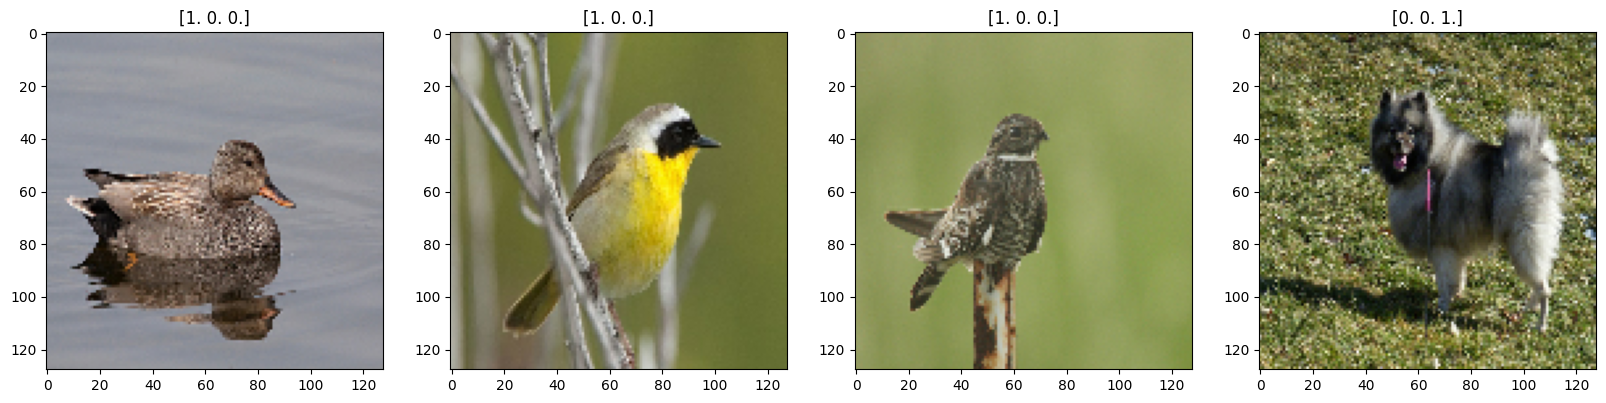

In [ ]:
# plot first 4 images and display corresponding labels
# 1 0 0 birds, 0 0 1 dogs , 0 1 0 cats
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img) # as int before scaling but after scaling they are between [0,1]
    ax[idx].title.set_text(batch[1][idx])

## Scale Data

In [31]:
# data is a tf.data.Dataset containing (images, labels)
# we standardize the input so that instead of
# values between [0,255] we have [0,1]
data = data.map(lambda x,y: (x/255, y))

# testing and checking the values to be as edxpected
batch = data.as_numpy_iterator().next()
images = batch[0]

# Check the min and max values across the entire batch
min_val = np.min(images)
max_val = np.max(images)

print("Min pixel value:", min_val)
print("Max pixel value:", max_val)

Min pixel value: 0.0
Max pixel value: 1.0


## Split Data

In [32]:
# split data into train, val and test
# Define proportions
train_split = 0.7
val_split = 0.2
test_split = 0.1

# Calculate split sizes
train_size = int(len(data)*train_split)
val_size = int(len(data)*val_split)
test_size = int(len(data)*test_split)

print("Train size:", train_size)
print("Validation size:", val_size)
print("Test size:", test_size)

Train size: 420
Validation size: 120
Test size: 60


In [33]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Building the models

In [34]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [35]:
# --- Simple CNN with 2 convolution layers + 1 output layer
def build_simple_cnn(kernel_size=(3,3)):
    model = Sequential([
        Conv2D(32, kernel_size, activation='relu', input_shape=(*IMAGE_SIZE, 3)),
        MaxPooling2D(),

        Conv2D(64, kernel_size, activation='relu'),
        MaxPooling2D(),
        Flatten(),

        Dense(128, activation='relu'),
        Dropout(0.5), # avoid overfitting
        Dense(NUM_CLASSES, activation='softmax')
    ])
    return model



In [68]:
# --- UPDATED Simple CNN with 2 convolution layers + 1 output layer
# am adaugat dropout (0.3) dupa fiecare strat + kernel_regularizer 
# pentru a incerca sa evit overfitting ul pe care il facea inainte
def build_simple_cnn2(kernel_size=(3,3)):
    model = Sequential([
        Conv2D(32, 
               kernel_size, 
               activation='relu', 
               input_shape=(*IMAGE_SIZE, 3), 
               kernel_regularizer=regularizers.l2(0.001) # added this
               ),
        BatchNormalization(),
        MaxPooling2D(), 
        Dropout(0.3), # added this


        Conv2D(64, 
               kernel_size, 
               activation='relu',
               kernel_regularizer=regularizers.l2(0.001)# added this
               ),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.3), # added this
        Flatten(),

        Dense(128, 
              activation='relu', 
              kernel_regularizer=regularizers.l2(0.001)),# added this
        Dropout(0.5), # avoid overfitting
        Dense(NUM_CLASSES, activation='softmax')
    ])
    return model



In [36]:
def build_complex_cnn(kernel_size=(3,3)):
    model = Sequential([
        Conv2D(32, kernel_size, activation='relu', input_shape=(*IMAGE_SIZE, 3)),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(64, kernel_size, activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(128, kernel_size, activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(256, kernel_size, activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5), # avoid overfitting
        Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

## Main functions for compiling and training the models

In [37]:
# Compile
def compile_model(model, optimizer):
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

#Train
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

def train_model(model, train_data, val_data, epochs=10):
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=[tensorboard_callback]
    )
    return history

## Actually Training the models

In [ ]:
# Simple cnn 1 -> kernel (3,3)
model1 = build_simple_cnn(kernel_size=(3,3))
model1 = compile_model(model1, Adam())

model1.summary()

hist1 = train_model(model1, train, val)

# these results are for the original simple model that has some
# overfitting issues, since I changed my model and ran it in 
# a separate notebook. both models are saved and are compared
# lower in another section of the notebook


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,707 (28.20 MB)

 Trainable params: 7,392,707 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 134s 315ms/step - accuracy: 0.6354 - loss: 1.0237 - val_accuracy: 0.7422 - val_loss: 0.6364
Epoch 2/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 116s 277ms/step - accuracy: 0.7494 - loss: 0.5969 - val_accuracy: 0.7799 - val_loss: 0.5287
Epoch 3/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 124s 294ms/step - accuracy: 0.8028 - loss: 0.4807 - val_accuracy: 0.7974 - val_loss: 0.4920
Epoch 4/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 115s 274ms/step - accuracy: 0.8421 - loss: 0.3951 - val_accuracy: 0.8044 - val_loss: 0.4850
Epoch 5/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 109s 260ms/step - accuracy: 0.8797 - loss: 0.3108 - val_accuracy: 0.7797 - val_loss: 0.5577
Epoch 6/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 122s 291ms/step - accuracy: 0.9121 - loss: 0.2298 - val_accuracy: 0.8128 - val_loss: 0.5516
Epoch 7/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 124s 294ms/step - accuracy: 0.9387 - loss: 0.1738 - val_accuracy: 0.8133 - val_loss: 0.6048
Epoch 8/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 111s 264ms/step - accuracy: 0.9460 -

In [39]:
# Complex cnn 2 -> kernel (3,3)
model2 = build_complex_cnn(kernel_size=(3,3))
model2 = compile_model(model2, SGD())

# Print summary BEFORE training
model2.summary()

hist2 = train_model(model2, train, val)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,750,659 (10.49 MB)

 Trainable params: 2,749,699 (10.49 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 228s 540ms/step - accuracy: 0.6739 - loss: 0.9374 - val_accuracy: 0.6969 - val_loss: 0.6988
Epoch 2/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 234s 556ms/step - accuracy: 0.7901 - loss: 0.5095 - val_accuracy: 0.7667 - val_loss: 0.5446
Epoch 3/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 234s 557ms/step - accuracy: 0.8327 - loss: 0.4189 - val_accuracy: 0.8154 - val_loss: 0.4414
Epoch 4/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 232s 551ms/step - accuracy: 0.8530 - loss: 0.3651 - val_accuracy: 0.8404 - val_loss: 0.3976
Epoch 5/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 228s 543ms/step - accuracy: 0.8711 - loss: 0.3211 - val_accuracy: 0.8453 - val_loss: 0.4011
Epoch 6/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 231s 550ms/step - accuracy: 0.8923 - loss: 0.2712 - val_accuracy: 0.8445 - val_loss: 0.3832
Epoch 7/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 232s 551ms/step - accuracy: 0.9098 - loss: 0.2249 - val_accuracy: 0.8398 - val_loss: 0.4211
Epoch 8/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 251s 598ms/step - accuracy: 0.9238 -

## Plot Performance

In [62]:
# since I created the first model twice, I saved the histories using pickle
# so that I could compare the initial model and the second model and then those simple models
# with my complex one.

#as such, for histories I send the actual history .pkl file

def compare_histories_pairwise(hist1, hist2, name1="Model 1", name2="Model 2"):
    plt.figure(figsize=(14, 6))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    if 'accuracy' in hist1:
        plt.plot(hist1['accuracy'], label=f"{name1} Train Acc")
    if 'val_accuracy' in hist1:
        plt.plot(hist1['val_accuracy'], linestyle='--', label=f"{name1} Val Acc")
    
    if 'accuracy' in hist2:
        plt.plot(hist2['accuracy'], label=f"{name2} Train Acc")
    if 'val_accuracy' in hist2:
        plt.plot(hist2['val_accuracy'], linestyle='--', label=f"{name2} Val Acc")

    plt.title("Accuracy Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(hist1['loss'], label=f"{name1} Train Loss")
    plt.plot(hist1['val_loss'], linestyle='--', label=f"{name1} Val Loss")

    plt.plot(hist2['loss'], label=f"{name2} Train Loss")
    plt.plot(hist2['val_loss'], linestyle='--', label=f"{name2} Val Loss")

    plt.title("Loss Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [63]:
# load saved histories
import pickle

# simple model with a bit too much accuracy so it reaches overfit
# the val loss drops initially but started increasing by epoch 4
with open('histories/hist1_overfit.pkl', 'rb') as f:
    hist1_history = pickle.load(f)


# complex model - has a bit of overfit which could be fixed
# by adding more dropout between layers, adding kernel_regularizer, etc.
with open('histories/hist2.pkl', 'rb') as f:
    hist2_history = pickle.load(f) 

# simple model with less accuracy and less overfit
# it might need some early stopping or other measures for fixing the underfit
with open('histories/hist1_vers2.pkl', 'rb') as f:
    hist1_history2 = pickle.load(f) 


### Comparing the original simple model and the updated simple model

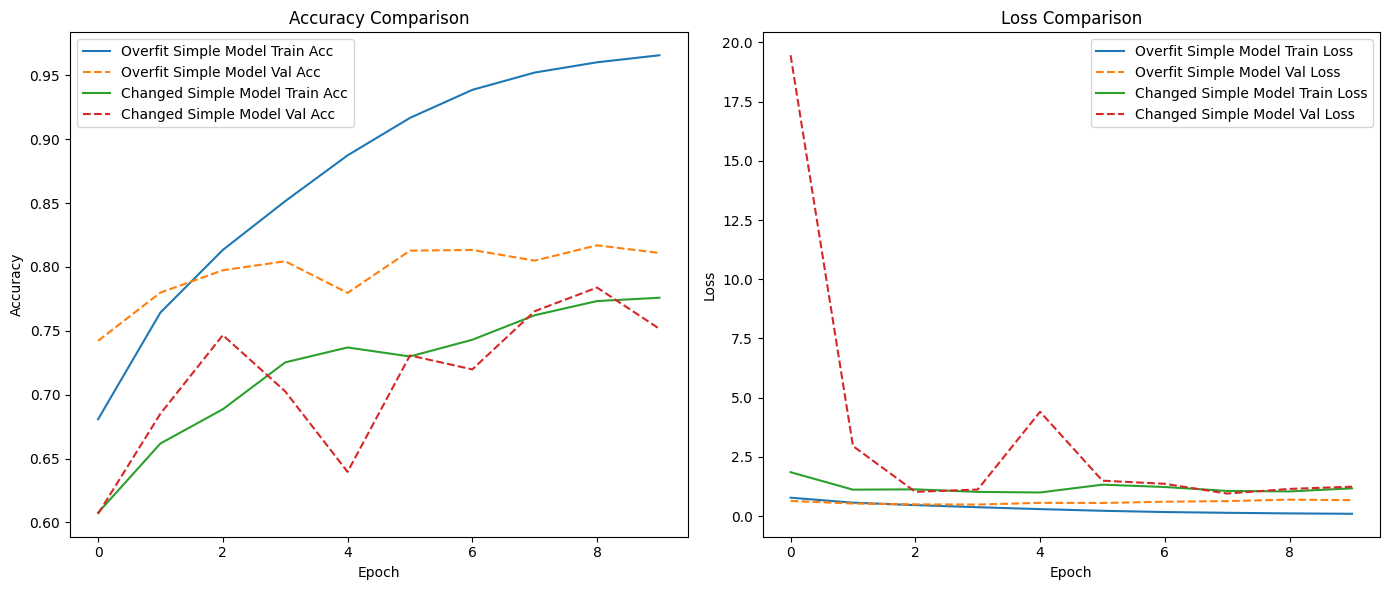

In [64]:
compare_histories_pairwise(hist1_history, hist1_history2, "Overfit Simple Model", "Changed Simple Model")

### Comparing the original simple model with the complex model

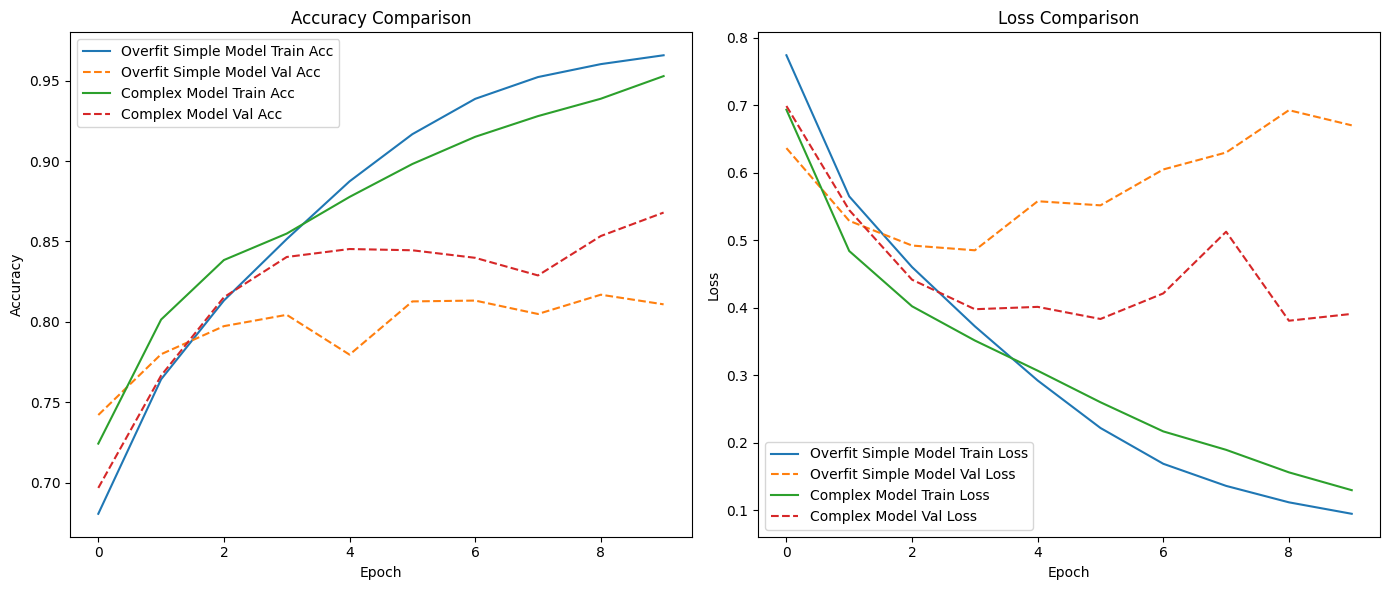

In [65]:
compare_histories_pairwise(hist1_history, hist2_history, "Overfit Simple Model", "Complex Model")

### Comparing the updated simple model with the complex model

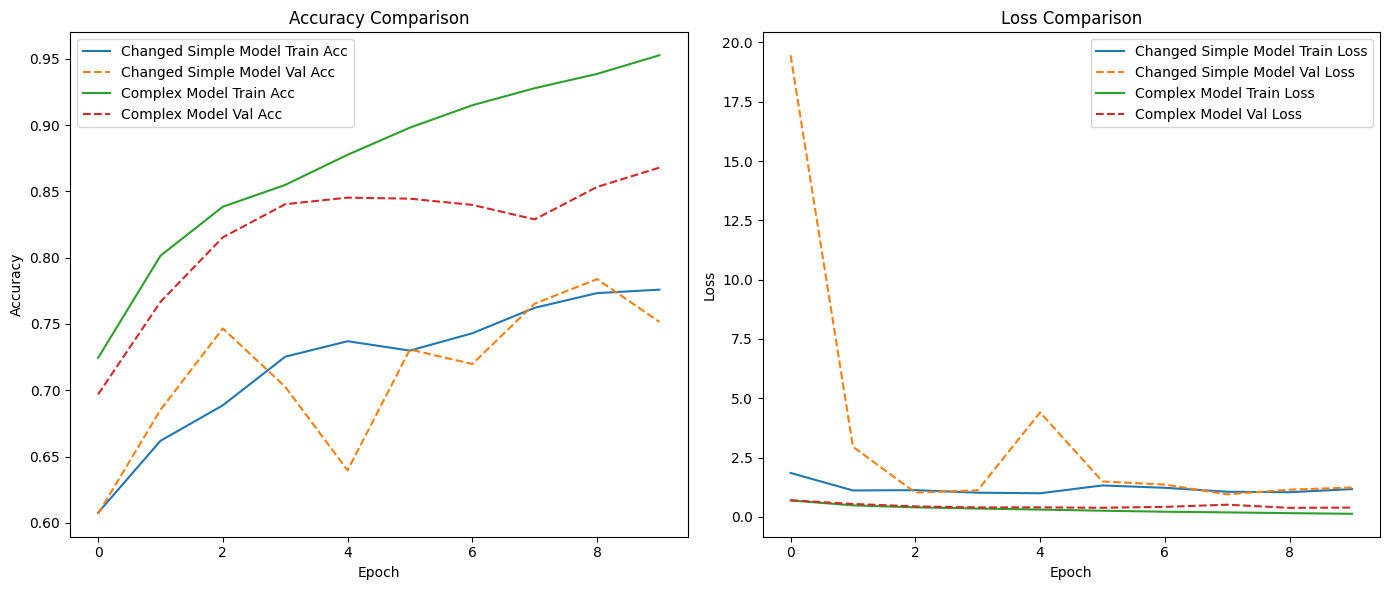

In [66]:
compare_histories_pairwise(hist1_history2, hist2_history, "Changed Simple Model", "Complex Model")

Model 1 – Simple (initial, kernel 3x3):
This one clearly suffers from overfitting. Training accuracy goes up, but validation loss increases a lot after epoch 4. Overall accuracy is okay, but it overfits really fast. It's basically an overfitting case caused by too little convolution and too many fully connected layers.

How I tried to fix it:
- I added kernel_regularizer=regularizers.l2(0.001) to each convolutional layer. this applies L2 regularization to the kernel weights, meaning I add an extra term to the loss function that penalizes large weights (basically discouraging the model from relying too heavily on any one weight).
- I also added more dropout, including between convolutions (0.3), instead of just having a single 0.5 dropout before the final dense layer.

Result: 
- Accuracy is a bit lower (the initial val loss is quite high so you can’t really see the improvement clearly in the loss plots), but at least the val loss doesn’t keep increasing like before. The model behaves more in line with the validation set now.

Model 2 complex (kernel 3x3): 
This model is more stable than the first one, and overfitting kicks in later. It holds up better mainly because it has more convolutional layers to extract features gradually.

At epoch 7 there's a spike in val loss, but since I only trained it for 10 epochs, it doesn't start overfitting too badly. Also, validation accuracy stays pretty close to training accuracy.

# 9. Evaluate

In [ ]:
def evaluate_with_tf_metrics(model, dataset):
    # use categorical accuracy metric
    acc = tf.keras.metrics.CategoricalAccuracy()
    
    # for precision and recall, accumulate predictions and true labels,
    # then compute using sklearn for macro averaging:
    y_trues = []
    y_preds = []
    
    for X, y in dataset.as_numpy_iterator():
        yhat_probs = model.predict(X)
        yhat_classes = np.argmax(yhat_probs, axis=1)
        y_true_classes = np.argmax(y, axis=1)
        
        y_trues.extend(y_true_classes)
        y_preds.extend(yhat_classes)
        
        acc.update_state(y, yhat_probs)
    
    print(f"TensorFlow Categorical Accuracy: {acc.result().numpy():.4f}")
    
    from sklearn.metrics import precision_score, recall_score, f1_score
    precision = precision_score(y_trues, y_preds, average='macro')
    recall = recall_score(y_trues, y_preds, average='macro')
    f1 = f1_score(y_trues, y_preds, average='macro')
    
    print(f"Sklearn Metrics:\n Precision (macro): {precision:.4f}, Recall (macro): {recall:.4f}, F1 (macro): {f1:.4f}")


Loading my models and evaluating them with the metrics

In [67]:
from tensorflow.keras.models import load_model

model1_of = load_model('models/imageclassifier_model1.h5')
model1_up = load_model('models/imageclassifier_model1_updated.h5')
model2 = load_model('models/imageclassifier_model2.h5')

print("Evaluating Original Model 1:")
evaluate_with_tf_metrics(model1_of, test)

print("Evaluating Updated Model 1:")
evaluate_with_tf_metrics(model1_up, test)

print("Evaluating Model 2:")
evaluate_with_tf_metrics(model2, test)


Evaluating Original Model 1:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━

Model 1 Original:
Precision: 0.8029, Recall: 0.7885, Accuracy: 0.8650

Model 1 Updated:
Precision: 0.8111, Recall: 0.7176, Accuracy: 0.8502

Model 2:
Precision: 0.8669, Recall: 0.8472, Accuracy: 0.9057

In [70]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def plot_confusion_matrix_heatmap(model, dataset, class_names):
    y_true = []
    y_pred = []
    for X_batch, y_batch in dataset.as_numpy_iterator():
        preds = model.predict(X_batch)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(y_batch, axis=1))
    
    cm = confusion_matrix(y_true, y_pred)
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
    
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix Heatmap')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━

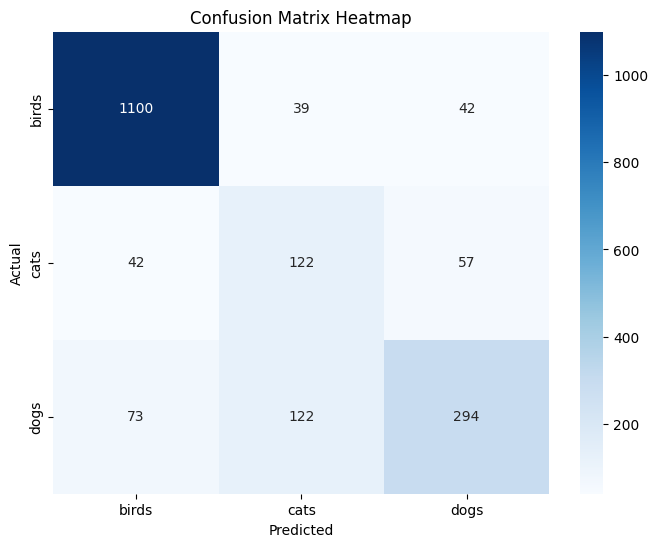

In [71]:
class_names = ['birds', 'cats', 'dogs']
plot_confusion_matrix_heatmap(model1_of, test, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

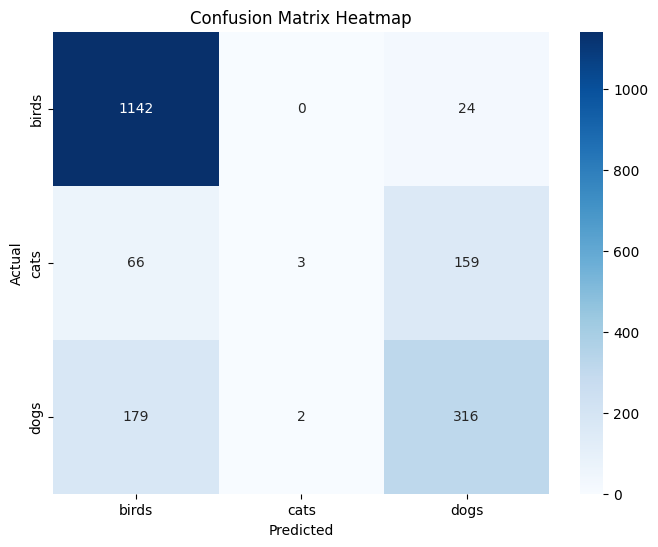

In [72]:
class_names = ['birds', 'cats', 'dogs']
plot_confusion_matrix_heatmap(model1_up, test, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

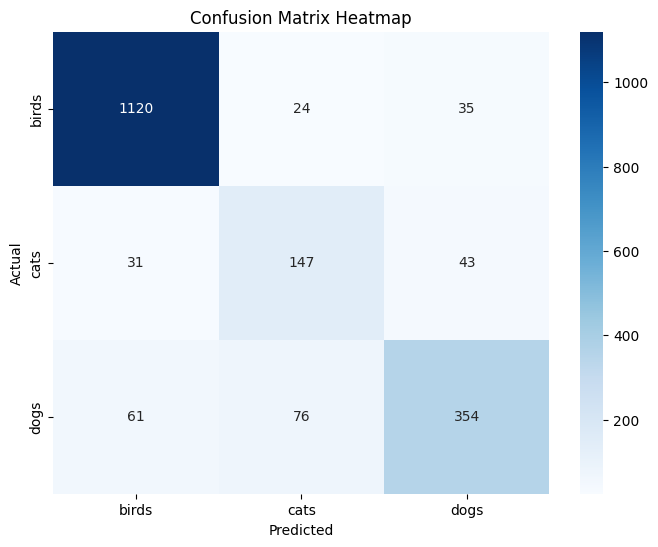

In [73]:
class_names = ['birds', 'cats', 'dogs']
plot_confusion_matrix_heatmap(model2, test, class_names)

The colors arent super meaningful here because the bird image set is about twice the size of the cat and dog sets. 
Still, the main diagonal generally has the highest values, which means most images are being classified correctly overall. 

The exception is the second version of the simple model (the one where I tried to reduce overfitting) — you can see some confusion between dogs and cats (and for some reason, also a little bit between dogs and birds :) ).

## Save models


In [ ]:
import os
from tensorflow.keras.models import load_model

# Make sure the directory exists
os.makedirs('models', exist_ok=True)

# Save model1
model1.save(os.path.join('models', 'imageclassifier_model1.h5'))

#model1_loaded = load_model(os.path.join('models', 'imageclassifier_model1.h5'))

# Save model2
model2.save(os.path.join('models', 'imageclassifier_model2.h5'))

#model2_loaded = load_model(os.path.join('models', 'imageclassifier_model2.h5'))


## Shap

In [ ]:
def shap_explanation(model, dataset, num_samples=3):
    # Extract some images from dataset (non-batched)
    images = []
    labels = []
    for X_batch, y_batch in dataset.unbatch().take(num_samples):
        images.append(X_batch.numpy())
        labels.append(np.argmax(y_batch.numpy()))
    
    background = images[:10] if len(images) >= 10 else images  # small background set for SHAP

    # DeepExplainer: Note model input shape (batch size is dynamic)
    explainer = shap.DeepExplainer(model, background)
    shap_values = explainer.shap_values(np.array(images))

    # shap_values is a list for each class, with shape (num_samples, H, W, channels)

    # plot SHAP values on images (for predicted class)
    for i, img in enumerate(images):
        pred_class = np.argmax(model.predict(img[np.newaxis, ...]))
        shap.image_plot([shap_values[pred_class][i]], [img])


In [ ]:
# used this to save my histories 
import os
import pickle

with open('hist1_overfit.pkl', 'wb') as f:
    pickle.dump(hist1.history, f)

print(os.path.getsize('hist2.pkl'))

436
